Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
%matplotlib inline

#for text cleaning
import string
import re
import nltk
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

!pip install scikit-plot
from scikitplot.estimators import plot_feature_importances
from scikitplot.metrics import plot_confusion_matrix, plot_roc

#Library for evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,classification_report
from scikitplot.metrics import plot_confusion_matrix, plot_roc

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
tweets = pd.read_csv("/content/training_data- disasters related tweets.csv")
tweets.head()

,date,text,user_location
0,2023-02-10 23:17:11+00:00,@simonkjaer1989 @acmilan @acmilanbr @acmilanar...,NaN
1,2023-02-10 21:16:06+00:00,Hi People...any help here would be much apprec...,"London, England"
2,2023-02-10 20:34:38+00:00,@JLo @intimissimi #TurkeyQuake we are in desp...,NaN
3,2023-02-10 19:08:06+00:00,thank you rafael this means a lot 😭😭😭💜 #Turkey...,NaN
4,2023-02-10 19:03:17+00:00,@adgpi Hey @BBCWorld try to cover these storie...,India


In [ ]:
tweets.shape

(29844, 3)

Preprocessing and cleaning

In [ ]:
def preprocess_data(data):
    # Removal of URL
    text = re.sub(r'https?://\S+|www\.\S+|http?://\S+', ' ', data)

    # Decontraction (expanding contractions - expanding shortened forms of words)
    text = re.sub(r"won\'t", " will not", text)
    text = re.sub(r"won\'t've", " will not have", text)
    text = re.sub(r"can\'t", " can not", text)
    text = re.sub(r"don\'t", " do not", text)
    text = re.sub(r"can\'t've", " can not have", text)
    text = re.sub(r"ma\'am", " madam", text)
    text = re.sub(r"let\'s", " let us", text)
    text = re.sub(r"ain\'t", " am not", text)
    text = re.sub(r"shan\'t", " shall not", text)
    text = re.sub(r"sha\n't", " shall not", text)
    text = re.sub(r"o\'clock", " of the clock", text)
    text = re.sub(r"y\'all", " you all", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"n\'t've", " not have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'d've", " would have", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ll've", " will have", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(u'http\S+', u'', text)
    text = re.sub(u'(\s)@\w+', u'', text)
    text = re.sub(u'#', u'', text)
    text = re.sub(u'RT', u'', text)

    # Removal of HTML tags
    text = re.sub(r'<.*?>', ' ', text)

    # Removal of emojis
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"  # dingbats
                               u"\U000024C2-\U0001F251"  # enclosed characters
                               "]+")
    text = emoji_pattern.sub(' ', text)

    # Filtering out miscellaneous text
    text = re.sub('[^a-zA-Z0-9]', ' ', text)
    text = re.sub(r"\([^()]*\)", "", text)

    # Remove mentions
    text = re.sub('@\S+', '', text)

    # Remove punctuations
    text = re.sub('[%s]' % re.escape("""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"""), '', text)

    # Lowercase all the words in text
    text = text.lower()
    text = text.split()

    # Removal of words with length < 2
    text = [i for i in text if len(i) > 2 or i.isnumeric()]
    text = ' '.join(text)
    return text

In [ ]:
tweets = tweets[['text']].fillna('')
tweets['clean_tweet'] = tweets['text'].apply(lambda txt: preprocess_data(txt))

In [ ]:
def replace_abbreviations(text):
    abbreviations = {
        "lol": "laughing out loud",
        "omg": "oh my god",
        "btw": "by the way",
        "idk": "I don't know",
        "omw": "on my way",
        "brb": "be right back",
        "imo": "in my opinion",
        "tbh": "to be honest",
        "fyi": "for your information",
        "wtf": "what the heck",
        "gtg": "got to go",
        "afk": "away from keyboard",
        "irl": "in real life",
        "bff": "best friends forever",
        "gr8": "great",
        "np": "no problem",
        "thx": "thanks",
        "yw": "you're welcome",
        # Add more abbreviations and their full forms as needed
    }
    words = text.split()
    replaced_words = [abbreviations[word] if word in abbreviations else word for word in words]
    replaced_text = " ".join(replaced_words)
    return replaced_text

In [ ]:
tweets["clean_tweet"] = tweets["clean_tweet"].apply(replace_abbreviations)

In [ ]:
# Removing stopwords. (a.is,an,the,in)

stop_words = set(stopwords.words('english'))
def remove_stopwords(text):
    # Tokenize the text into words
    tokens = word_tokenize(text)
    tokens = [token.lower() for token in tokens]    # lowercasing
    # Remove stopwords from the tokenized words
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words]

    # Join the filtered tokens back into a sentence
    filtered_text = ' '.join(filtered_tokens)

    return filtered_text

In [ ]:
tweets["clean_tweet"] = tweets["clean_tweet"].apply(remove_stopwords)

In [ ]:
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

# Initialize the lemmatizer                ##used to reduce words to their base or dictionary form
lemmatizer = WordNetLemmatizer()

def lemmatize(text):
  lemmatize_text = [lemmatizer.lemmatize(text) for word in text]
  return text

[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
tweets["clean_tweet"] = tweets["clean_tweet"].apply(lemmatize)
tweets.sample(5)

,text,clean_tweet
13522,#BREAKING | #AlMayadeen delegate: A 77-year-ol...,breaking almayadeen delegate 77 year old man r...
7417,Its vital Internet connection and social media...,vital internet connection social media access ...
20380,.@HKUST community comes together and responds ...,hkust community comes together responds call h...
4507,Earthquake M3.1 - Turkey: GUZELBURC-(HATAY)\n#...,earthquake 1 turkey guzelburc hatay earthquake...
582,"Rescue ship ""Nene Hatun"" left Istanbul with a ...",rescue ship nene hatun left istanbul cargo eme...


Labelling the data along with sentiment

In [ ]:
from textblob import TextBlob

def get_polarity(text):
    return TextBlob(text).sentiment.polarity

def get_sentiment(score):
    if score > 0:
        return 'Positive'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Negative'

In [ ]:
tweets['polarity'] = tweets['clean_tweet'].apply(get_polarity)
tweets['sentiment'] = tweets['polarity'].apply(get_sentiment)
tweets.head()

,text,clean_tweet,polarity,sentiment
0,@simonkjaer1989 @acmilan @acmilanbr @acmilanar...,simonkjaer1989 simon fenerbah supporter hear,0.000000,Neutral
1,Hi People...any help here would be much apprec...,people help would much appreciated quick legit...,0.266667,Positive
2,@JLo @intimissimi #TurkeyQuake we are in desp...,jlo turkeyquake desperate please help jennifer...,-0.050000,Negative
3,thank you rafael this means a lot 😭😭😭💜 #Turkey...,thank rafael means lot turkeyquake rkiye deprem,0.000000,Neutral
4,@adgpi Hey @BBCWorld try to cover these storie...,adgpi hey try cover stories absolute truth tur...,0.200000,Positive


In [ ]:
# View sentiment counts

tweets.sentiment.value_counts()

Neutral     16445
Positive     8532
Negative     4867
Name: sentiment, dtype: int64

In [ ]:
# splitting along with category.....
X = tweets['clean_tweet']
y = tweets['sentiment']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=35) # X = SET OF FEATURES EXTRACTED...

N-gram Analysis

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
# top n-grams
def top_ngrams(data,n,grams):
    count_vec = CountVectorizer(ngram_range=(grams,grams)).fit(data)
    bow = count_vec.transform(data)
    add_words = bow.sum(axis=0)
    word_freq = [(word, add_words[0, idx]) for word, idx in count_vec.vocabulary_.items()]
    word_freq = sorted(word_freq, key = lambda x: x[1], reverse=True)
    return word_freq[:n]

In [ ]:
common_uni = top_ngrams(tweets["clean_tweet"],10,1)
common_bi = top_ngrams(tweets["clean_tweet"],10,2)
common_tri = top_ngrams(tweets["clean_tweet"],10,3)
common_uni_df = pd.DataFrame(common_uni,columns=['word','freq'])
common_bi_df = pd.DataFrame(common_bi,columns=['word','freq'])
common_tri_df = pd.DataFrame(common_tri,columns=['word','freq'])

In [ ]:
fig = make_subplots(rows=3, cols=1,subplot_titles=("Top 10 Unigrams in Text", "Top 10 Bigrams in Text","Top 10 Trigrams in Text"))

fig.add_trace(
      go.Bar(x=common_uni_df["word"],y=common_uni_df["freq"],
             marker=dict(color= 'rgba(255, 170, 59,0.8)'),
             marker_line=dict(color='black'),marker_line_width=1.2),
      row=1, col=1
).add_trace(
      go.Bar(x=common_bi_df["word"],y=common_bi_df["freq"],
             marker=dict(color= 'rgba(89, 255, 147,0.8)'),
             marker_line=dict(color='black'),marker_line_width=1.2),
      row=2, col=1
).add_trace(
      go.Bar(x=common_tri_df["word"],y=common_tri_df["freq"],
             marker=dict(color= 'rgba(89, 153, 255,0.8)'),
             marker_line=dict(color='black'),marker_line_width=1.2),
      row=3, col=1
).update_layout(title_text="Visualization of Top 10 Unigrams, Bigrams and Trigrams",
                title_x=0.5,showlegend=False,width=800,height=1600,).update_xaxes(tickangle=-90).show()

In [ ]:
# getting bag of features
def TFIDF(data, ngram = 1, MAX_NB_WORDS = 75000):
    tfidf_x = TfidfVectorizer(ngram_range = (ngram, ngram), max_features = MAX_NB_WORDS)
    emb = tfidf_x.fit_transform(data).toarray()
    print("tf-idf with", str(np.array(emb).shape[1]), "features")
    return emb, tfidf_x

def print_out(emb, feat, ngram, compared_sentence=0):
    print(ngram,"bag-of-words: ")
    print(feat.get_feature_names_out(), "\n")
    print(ngram,"bag-of-feature: ")
    print(test_tfidf_3gram.vocabulary_, "\n")
    print("BoW matrix:")
    print(pd.DataFrame(emb.transpose(), index = feat.get_feature_names_out()).head(), "\n")
    print(ngram,"vector example:")
    print(tweets["clean_tweet"][compared_sentence])
    print(emb[compared_sentence], "\n")

In [ ]:
#tri-gram
test_corpus = tweets["clean_tweet"][:10].tolist()
print("The test corpus: ", test_corpus, "\n")
test_tfidf_em_3gram, test_tfidf_3gram = TFIDF(test_corpus, ngram=3)
print_out(test_tfidf_em_3gram, test_tfidf_3gram, ngram="Tri-gram")

The test corpus:  ['simonkjaer1989 simon fenerbah supporter hear', 'people help would much appreciated quick legit reaction try', 'jlo turkeyquake desperate please help jennifer love ahbapdernegi hatay afad', 'thank rafael means lot turkeyquake rkiye deprem', 'adgpi hey try cover stories absolute truth turkeyquake rather making baseless', 'picture day turkeyquake syrianeedshelp helpsyrianpeople earthquakeinsyria isro operationdost', 'support affected earthquakes use charity wallet eth 0xd3bd9b3c442647daedf7ad8510b1480ba606ddd2', 'cant believe see turkeysyriaearthquake earthquaketurkey', 'help turkey earthquake disaster occurred turkey urgently lack tent support country', 'help turkey earthquake disaster occurred turkey urgently lack tent support country plea'] 

tf-idf with 57 features
Tri-gram bag-of-words: 
['absolute truth turkeyquake' 'adgpi hey try' 'affected earthquakes use'
 'ahbapdernegi hatay afad' 'appreciated quick legit'
 'believe see turkeysyriaearthquake' 'cant believe se

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Create an instance of TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(ngram_range = (3,3))# trigram

# tfidf along with sentiment..
# Perform feature extraction on the training data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Transform the testing data using the learned vocabulary from the training data
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [ ]:
# classification report.

from sklearn.metrics import classification_report,accuracy_score,confusion_matrix
def c_report(y_true,y_pred):
    accuracy=round(accuracy_score(y_test,y_pred),3)
    precision=round(precision_score(y_test,y_pred,average='weighted'),3)
    recall=round(recall_score(y_test,y_pred,average='weighted'),3)
    print(f'Accuracy of the model: {np.round(accuracy*100,2)}%')
    print('-'*50)
    print("Classifictaion Report")
    print(classification_report(y_true, y_pred))
    acc_scr = accuracy_score(y_true, y_pred)
    return acc_scr

def plot_cm(y_true,y_pred,cmap = "Blues"):
    mtx = confusion_matrix(y_true, y_pred)
    sns.heatmap(mtx, annot = True, fmt='d', linewidth=0.5,
               cmap='YlGnBu')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

Model Building - SVC, Random Forest and Logistic Regression

In [ ]:
# Build SVC model
from sklearn.svm import SVC
svc_model = SVC(kernel='linear',gamma='auto')
# Train the model
svc_model.fit(X_train_tfidf, y_train)

SVC(gamma='auto', kernel='linear')

In [ ]:
# Make predictions on the testing set
y_svc_pred = svc_model.predict(X_test_tfidf)

Accuracy of the model: 94.8%
--------------------------------------------------
Classifictaion Report
              precision    recall  f1-score   support

    Negative       0.93      0.86      0.89       940
     Neutral       0.94      0.99      0.97      3317
    Positive       0.97      0.91      0.94      1712

    accuracy                           0.95      5969
   macro avg       0.95      0.92      0.93      5969
weighted avg       0.95      0.95      0.95      5969



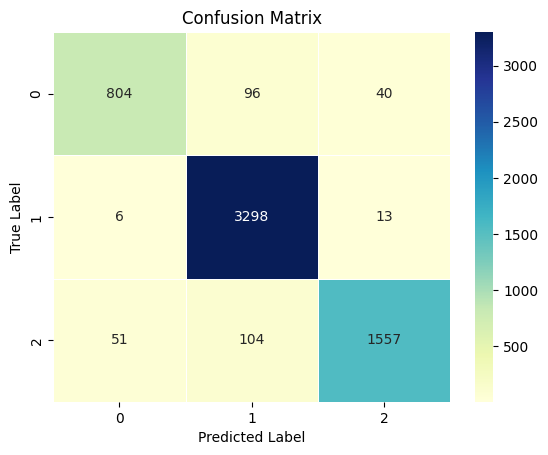

In [ ]:
# Evaluate the model
SVC_c_report = c_report(y_test, y_svc_pred)
plot_cm(y_test, y_svc_pred)

In [ ]:
# Build Random Forest Model
from sklearn.ensemble import RandomForestClassifier

# Create a Random Forest classifier object
rf_model = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=2, min_samples_leaf=1, max_features='auto')
rf_model.fit(X_train_tfidf, y_train)

RandomForestClassifier(max_features='auto')

In [ ]:
# Make predictions on the testing set
y_rf_pred = rf_model.predict(X_test_tfidf)

Accuracy of the model: 93.1%
--------------------------------------------------
Classifictaion Report
              precision    recall  f1-score   support

    Negative       0.94      0.80      0.87       940
     Neutral       0.92      0.99      0.96      3317
    Positive       0.95      0.88      0.91      1712

    accuracy                           0.93      5969
   macro avg       0.94      0.89      0.91      5969
weighted avg       0.93      0.93      0.93      5969



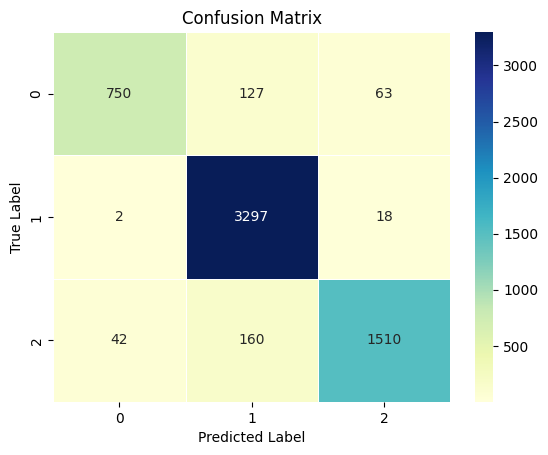

In [ ]:
# Evaluate the model
rf_c_report = c_report(y_test, y_rf_pred)
plot_cm(y_test, y_rf_pred)

In [ ]:
#build a logistic regression model
from sklearn.linear_model import LogisticRegression

# Create a Logistic Regression classifier object with specific parameters
lr_model = LogisticRegression(penalty='l2', C=1.0, solver='liblinear')
lr_model.fit(X_train_tfidf, y_train)

LogisticRegression(solver='liblinear')

In [ ]:
# Make predictions on the testing set
y_lr_pred = lr_model.predict(X_test_tfidf)

Accuracy of the model: 88.6%
--------------------------------------------------
Classifictaion Report
              precision    recall  f1-score   support

    Negative       0.94      0.65      0.77       940
     Neutral       0.86      0.99      0.92      3317
    Positive       0.93      0.81      0.87      1712

    accuracy                           0.89      5969
   macro avg       0.91      0.82      0.85      5969
weighted avg       0.89      0.89      0.88      5969



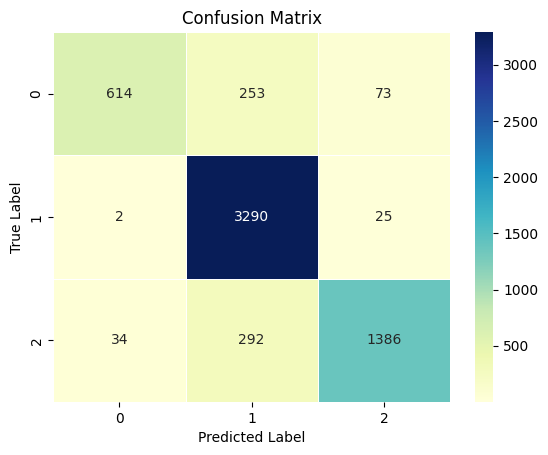

In [ ]:
# Evaluate the model
lr_c_report = c_report(y_test, y_lr_pred)
plot_cm(y_test, y_lr_pred)

Comparision table

In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tabulate import tabulate


models = ['SVC', 'Random Forest', 'Logistic Regression']  # List of model names
predictions = [y_svc_pred, y_rf_pred, y_lr_pred]  # List of predicted labels
true_labels = [y_test] * len(models)  # List of true labels

# Initialize lists to store evaluation metric values
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

# Iterate over each model and calculate the evaluation metrics
for i in range(len(models)):
    accuracy = accuracy_score(true_labels[i], predictions[i])
    precision = precision_score(true_labels[i], predictions[i], average='macro')
    recall = recall_score(true_labels[i], predictions[i], average='macro')
    f1 = f1_score(true_labels[i], predictions[i], average='macro')

    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

# Create a DataFrame to store the evaluation metrics for each model
data = []
for i in range(len(models)):
    data.append([models[i], accuracy_scores[i], precision_scores[i], recall_scores[i], f1_scores[i]])

# Define the table headers
headers = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1-score']

# Print the comparison table
table = tabulate(data, headers, tablefmt='github')
print(table)

| Model               |   Accuracy |   Precision |   Recall |   F1-score |
|---------------------|------------|-------------|----------|------------|
| SVC                 |   0.948065 |    0.947901 | 0.919685 |   0.932696 |
| Random Forest       |   0.930977 |    0.937865 | 0.891284 |   0.911629 |
| Logistic Regression |   0.886246 |    0.912155 | 0.81821  |   0.853228 |


Cross-validation of the best model

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.svm import SVC


# Create a classifier object (e.g., Support Vector Classifier)
clf = SVC(kernel='linear', degree=3, gamma='auto')

# Define the number of folds for cross-validation
k = 5

# Perform cross-validation
cv_scores = cross_val_score(clf, X_train_tfidf, y_train, cv=k, scoring='accuracy')

# Print the accuracy scores for each fold
for fold_idx, score in enumerate(cv_scores):
    print(f"Fold {fold_idx + 1}: Accuracy = {score}")

# Calculate and print the average and standard deviation of accuracy scores
avg_accuracy = cv_scores.mean()
std_accuracy = cv_scores.std()
print(f"\nAverage Accuracy: {avg_accuracy}")
print(f"Standard Deviation of Accuracy: {std_accuracy}")

Fold 1: Accuracy = 0.9256544502617801
Fold 2: Accuracy = 0.9340314136125655
Fold 3: Accuracy = 0.9382198952879581
Fold 4: Accuracy = 0.9378010471204189
Fold 5: Accuracy = 0.9375916230366492

Average Accuracy: 0.9346596858638744
Standard Deviation of Accuracy: 0.004746124556805151


Saving and loading model

In [ ]:
import pickle

filename = 'trained_model.sav'
pickle.dump(svc_model, open(filename, 'wb'))

filename = 'tfidf_vectorizer.sav'
pickle.dump(tfidf_vectorizer,open(filename, 'wb'))

In [ ]:
# Load the saved model and vectorizer
SVC_model = pickle.load(open('/content/trained_model.sav', 'rb'))  # model trained along with sentiment
tfidf_Vectorizer = pickle.load(open('/content/tfidf_vectorizer.sav', 'rb'))

Testing Part

In [ ]:
df = pd.read_csv("/content/test_data- puebla_mexico_earthquake_2017.csv")

In [ ]:
df['clean_tweet'] = df['tweet_text'].apply(lambda txt: preprocess_data(txt))
df["clean_tweet"] = df["clean_tweet"].apply(replace_abbreviations)
df["clean_tweet"] = df["clean_tweet"].apply(remove_stopwords)
df["clean_tweet"] = df["clean_tweet"].apply(lemmatize)

In [ ]:
# Perform feature extraction on the new dataset
X_new_tfidf = tfidf_Vectorizer.transform(df["clean_tweet"] )

In [ ]:
# Make predictions on the new dataset along with category
test_pred = SVC_model.predict(X_new_tfidf)

In [ ]:
for tweets, label in zip(df["clean_tweet"], test_pred):
    print("Tweets:", tweets)
    print("Predicted Label:", label)
    print()

Tweets: dog named frida mission find survivors mexico deadly earthquake
Predicted Label: Neutral

Tweets: horrible news earthquake mexico thank god husband family safe mexico city prayers everyone
Predicted Label: Neutral

Tweets: frida rescue dog saved 50 people following powerful earthquake mexico
Predicted Label: Positive

Tweets: 6 2 magnitude strong earthquake strikes central mexico share amp
Predicted Label: Neutral

Tweets: look guys sharing love victims earthquake mexico city
Predicted Label: Neutral

Tweets: emmawatson teamly reminder earthquake mexico donate pray country could good way show solidarity
Predicted Label: Neutral

Tweets: wake earthquake central mexico people turned social media ask help give reports
Predicted Label: Neutral

Tweets: trapped girl symbol mexicos earthquake rescue efforts cbc news topstories
Predicted Label: Neutral

Tweets: meet frida rescue dog saved 50 lives mexico
Predicted Label: Neutral

Tweets: best way receive mexican watch tonight ill talk